# Тестовое задание
Информация о данных: https://ai.stanford.edu/~amaas/data/sentiment/

Короткое объяснение: требуется обучить модель на задачу классификации комментариев пользователей к фильмам, а также сделать возможным интерпретировать ответ в значения от 1 до 10 (например, звезд).

Также, оценки для положительных комментариев находятся в промежутке от 7 до 10, для отрицательных от 1 до 4

In [2]:
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
import pickle

from tqdm import tqdm
from catboost import CatBoostClassifier, CatBoostRegressor
from gensim.corpora import Dictionary
from gensim.models import Word2Vec
from gensim.utils import tokenize

import sklearn
import torch
import nltk

# Считаем данные

In [3]:
TRAIN_DATA_PATH = 'large-movie-reviews-dataset/acl-imdb-v1/train/'
TEST_DATA_PATH = 'large-movie-reviews-dataset/acl-imdb-v1/test/'

In [4]:
def get_rating(path):
    if path[-5] == '0' and path[-6] == '1':
        return 10
    else:
        return int(path[-5])

def get_target(path):
    if path[-4:-1] == 'pos':
        return 1
    else: 
        return 0

In [5]:
def open_txt(path):
    comments_names = os.listdir(path)
    comments = []
    for comment in tqdm(comments_names):
        with open(os.path.join(path, comment) , encoding="utf8") as f:
            lines = f.readlines()
            target = get_target(path)
            rating = get_rating(comment)
            comments.append([lines[0], target, rating])
    return comments

In [6]:
train_pos = open_txt(TRAIN_DATA_PATH + 'pos/')
train_neg = open_txt(TRAIN_DATA_PATH + 'neg/')
test_pos = open_txt(TEST_DATA_PATH + 'pos/')
test_neg = open_txt(TEST_DATA_PATH + 'neg/')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [01:26<00:00, 144.09it/s]


In [7]:
#словарь
with open('large-movie-reviews-dataset/acl-imdb-v1/imdb.vocab', encoding="utf8") as f:
        all_words = f.readlines()
for i in range(len(all_words)):
    all_words[i] = all_words[i][:-1]
print("Размер словаря, данного в этом датасете: ", len(all_words))

Размер словаря, данного в этом датасете:  89527


In [12]:
train_df = pd.DataFrame(train_pos + train_neg, columns = ['text', 'target', 'rating'])
train_df.head(3)

,text,target,rating
0,Bromwell High is a cartoon comedy. It ran at t...,1,9
1,Homelessness (or Houselessness as George Carli...,1,8
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,10


In [13]:
test_df = pd.DataFrame(test_pos + test_neg, columns = ['text', 'target', 'rating'])
test_df.head(3)

,text,target,rating
0,I went and saw this movie last night after bei...,1,10
1,Actor turned director Bill Paxton follows up h...,1,7
2,As a recreational golfer with some knowledge o...,1,9


# Токенизируем данные

In [14]:
punct_symbols = '"!@#$%^&*():;-+?_=,<>/'
def tokenizer_text(sent):
    tokens = [word.lower() for word in nltk.word_tokenize(sent)]
    tokens = [word for word in tokens if word not in punct_symbols]
    return tokens

In [15]:
train_df['tokenized'] = train_df['text'].apply(tokenizer_text)
test_df['tokenized'] = test_df['text'].apply(tokenizer_text)

In [16]:
train_df.sample(5)

,text,target,rating,tokenized
6072,In this excellent Twentieth-Century Fox film-n...,1,9,"[in, this, excellent, twentieth-century, fox, ..."
927,I love this movie. It is one of those movies t...,1,10,"[i, love, this, movie, ., it, is, one, of, tho..."
16997,Whoever wrote the script for this movie does n...,0,1,"[whoever, wrote, the, script, for, this, movie..."
8010,It's great to see Jorja Fox in a role where sh...,1,8,"[it, 's, great, to, see, jorja, fox, in, a, ro..."
14589,"This movie is nothing like ""Office Space"" exce...",0,1,"[this, movie, is, nothing, like, ``, office, s..."


In [17]:
dictionary = Dictionary(train_df['tokenized'])
dic = dictionary.token2id
inv_dic = {v: k for k, v in dic.items()}

In [18]:
len(dictionary)

111708

# Обертка на Word2Vec

In [19]:
class Word2VecWrap:
    def __init__(self, tokens, vec_size, window, min_count, epochs):
        self.tokens = tokens
        self.epochs = epochs
        self.vec_size = vec_size
        self.model_wv = Word2Vec(sentences=tokens,
                                 vector_size=vec_size,
                                 window=window,
                                 min_count=min_count)

    def train(self):
        self.model_wv.train(self.tokens, total_examples=len(self.tokens), epochs=self.epochs)

    def save(self, path):
        self.model_wv.save(path)

    def vocab(self):
        return self.model_wv.wv

# Обучаем и проверяем Word2Vec
Получать векторное представление предложения будем с помощью w2v, где эмбеддинги всех слов в предложении просто будем усреднять

In [ ]:
model_wv = Word2VecWrap(train_df['tokenized'], vec_size=64, window=5, min_count=3, epochs=15)
model_wv.train()

In [ ]:
len(model_wv.vocab()) #если бы min_count = 1, то слов бы было 115к

In [ ]:
model_wv.save('trained_word2vec.model')

In [21]:
model_wv_1 = Word2Vec.load('models/trained_word2vec.model')
model_wv_1.vector_size

64

In [32]:
def sent2vec_train(question, model):
    token_question = np.array(question)
    question_array = np.zeros(model.vector_size)
    count = 0
    for word in token_question:
        if model.wv.__contains__(str(word)):
            question_array += (np.array(model.wv[str(word)]))
            count += 1
    if count == 0:
        return question_array

    return question_array / count

In [33]:
def cos_sim(a, b):
    similarity = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return similarity

In [34]:
#Как мы видим word2vec работает, ембеддинговое пространство он построил 
mom = sent2vec_train(['mom'], model_wv_1)
dad = sent2vec_train(['dad'], model_wv_1)
fire = sent2vec_train(['fire'], model_wv_1)
print("Косинусное расстояние между словами мама и папа: ", cos_sim(mom, dad), '\n',
     "Косинусное расстояние между словами мама и огонь: ", cos_sim(mom, fire), sep='')

pos_1 = sent2vec_train(train_df['tokenized'][100], model_wv_1)
pos_2 = sent2vec_train(train_df['tokenized'][200], model_wv_1)
print("Косинусное расстояние между pos предложениями: ", cos_sim(pos_1, pos_2))

Косинусное расстояние между словами мама и папа: 0.8611133662145762
Косинусное расстояние между словами мама и огонь: 0.10754131355440777
Косинусное расстояние между pos предложениями:  0.8804037443559081


# Пишем обертку на CatBoost
Будем подавать эмбеддинги предложений в катбуст для предсказания таргета

Попробуем два разных подкхода к задаче: регрессия(предскажем оценку), классификация(предскажем класс, а оценку будет выставлять по вероятностным выходам модели)

## Classification

In [35]:
class CatBoostClassifierWrap:
    def __init__(self, n_estimators, max_depth, learning_rate, verbose=100):
        self.model = CatBoostClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   random_state=42,
                                   verbose=200)

    def fit(self, x_train, y_train):
        self.model.fit(x_train, y_train)

    def save(self, path):
        pickle.dump(self.model, open(path, "wb"))

    def predict(self, x):
        return self.model.predict(x)

    def predict_proba(self, x):
        return self.model.predict_proba(x)

In [40]:
def data_to_model(df, target):
    X, Y = [], []
    for sentence in range(len(df[target])):
        X.append(sent2vec_train(df['tokenized'][sentence], model_wv_1))
        Y.append(df[target][sentence])
    return np.array(X), np.array(Y)

In [41]:
assert len(sent2vec_train(train_df['tokenized'][0], model_wv_1)) == model_wv_1.vector_size

In [42]:
X_train_clf, Y_train_clf = data_to_model(train_df, 'target')
X_test_clf, Y_test_clf = data_to_model(test_df, 'target')

In [ ]:
model_cl = CatBoostClassifierWrap(n_estimators=1000, max_depth=6, learning_rate=0.1)
model_cl.fit(X_train_clf, Y_train_clf)

In [190]:
model_cl.save('cb_cl.model')

In [191]:
model_cl_1 = pickle.load(open('cb_cl.model', "rb"))

### Оценка результатов
Посмотрим на accuracy, recall, precision на трейне и на тесте

In [147]:
train_predicts = model_cl.predict(X_train_clf)
print('Accuracy: ', round((train_predicts == Y_train_clf).sum() / len(Y_train_clf), 4), '\n',
      'Precision: ', round(sklearn.metrics.precision_score(Y_train_clf, train_predicts), 4), '\n',
      'Recall: ', round(sklearn.metrics.recall_score(Y_train_clf, train_predicts), 4), sep='')

Accuracy: 0.9762
Precision: 0.9788
Recall: 0.9734


In [148]:
test_predicts = model_cl.predict(X_test_clf)
print('Accuracy: ', round((test_predicts == Y_test_clf).sum() / len(Y_test_clf), 4), '\n',
      'Precision: ', round(sklearn.metrics.precision_score(Y_test_clf, test_predicts), 4), '\n',
      'Recall: ', round(sklearn.metrics.recall_score(Y_test_clf, test_predicts), 4), sep='')

Accuracy: 0.8189
Precision: 0.8249
Recall: 0.8097


## Regressor

In [45]:
class CatBoostRegressorWrap:
    def __init__(self, n_estimators, max_depth, learning_rate, loss_function, verbose=100):
        self.model = CatBoostRegressor(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   random_state=42,
                                   loss_function=loss_function,
                                   verbose=200)

    def fit(self, x_train, y_train):
        self.model.fit(x_train, y_train)

    def save(self, path):
        pickle.dump(self.model, open(path, "wb"))

    def predict(self, x):
        return self.model.predict(x)

In [44]:
X_train_reg, Y_train_reg = data_to_model(train_df, 'rating')
X_test_reg, Y_test_reg = data_to_model(test_df, 'rating')

In [46]:
model_reg = CatBoostRegressorWrap(n_estimators=1000, max_depth=6, learning_rate=0.1, loss_function='MAE')
model_reg.fit(X_train_reg, Y_train_reg)

0:	learn: 3.1609149	total: 87.3ms	remaining: 1m 27s
200:	learn: 1.8273823	total: 3.09s	remaining: 12.3s
400:	learn: 1.6759578	total: 6.42s	remaining: 9.59s
600:	learn: 1.5890887	total: 9.56s	remaining: 6.35s
800:	learn: 1.5275910	total: 12.6s	remaining: 3.13s
999:	learn: 1.4835264	total: 15.6s	remaining: 0us


In [268]:
model_reg.save('cb_reg.model')

In [49]:
model_reg_1 = pickle.load(open('models/cb_reg.model', "rb"))

In [50]:
model_reg_1.predict(X_train_reg)

array([5.29482991, 4.50364583, 6.48478552, ..., 3.54330595, 4.00259353,
       0.78868154])

### Посмотрим на MAE и распределение таргетов

In [51]:
(Y_train_reg - model_reg_1.predict(X_train_reg)).mean()

0.05952989162641271

In [52]:
(Y_test_reg - model_reg_1.predict(X_test_reg)).mean()

0.15731421005743404

Ошибка на трейне 0.5 балла, на тесте 1.5 балла - довольно неплохой результат, выглядит ровно так же, как и человеческая погрешность в оценке чужих комментариев

In [53]:
sns.set(rc={'figure.figsize':(5, 3)})

Распределение на train

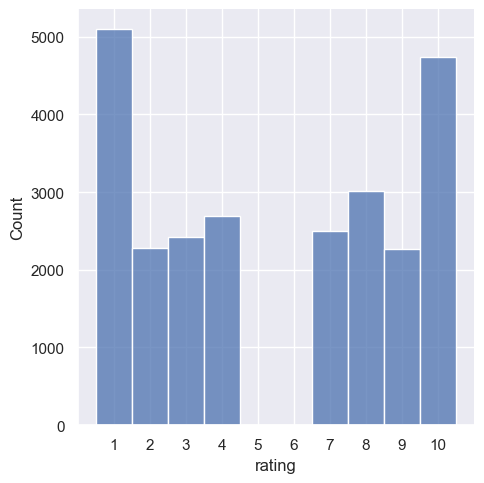

In [54]:
p = sns.displot(train_df, x ='rating', discrete=True)
p.set(xticks=np.arange(1,11))

Распределение на test

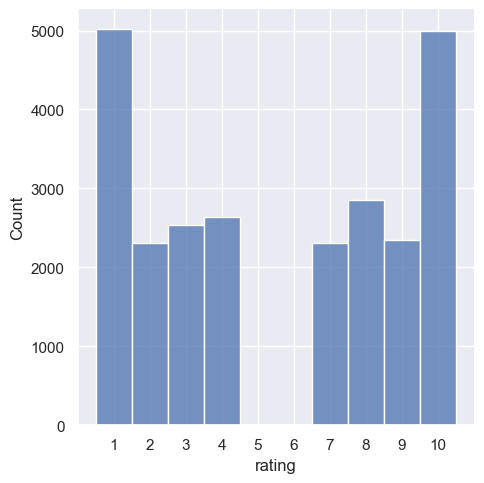

In [55]:
p = sns.displot(test_df, x ='rating', discrete=True)
p.set(xticks=np.arange(1,11))

Распределение предсказаний

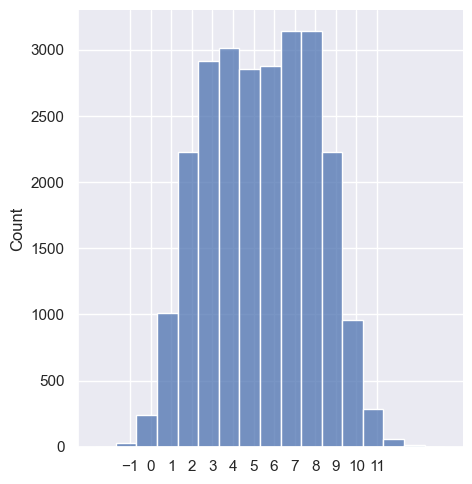

In [56]:
p = sns.displot(model_reg.predict(X_test_reg), discrete=True)
p.set(xticks=np.arange(-1,12))

Распределение предсказаний не очень похоже на реальное распределение. Видно, что предсказания кучкуются в интервале 4-6, а также есть выбросы за 1 и 10, их будем считать как оценку 1 и 10 соответственно. Попробуем сделать небольшие преобразования над нашими данными, чтобы оценка комментария была менее "нейтральной"

In [71]:
def remake(x):
    flag = -1 if x < 5 else 1
    treshold = 5 if x < 5 else 11
    x += flag * (treshold - x) * 0.5
    if x < 1:
        return 1
    if x > 10:
        return 10
    return x

remaker = np.vectorize(remake)

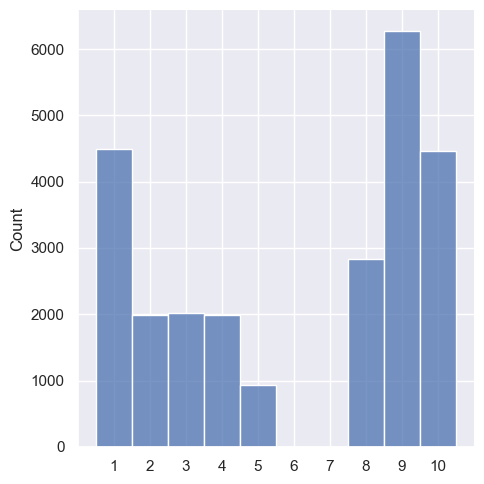

In [72]:
a = remaker(model_reg.predict(X_test_reg))
p = sns.displot(a, discrete=True)
p.set(xticks=np.arange(1,11))

In [70]:
abs((Y_test_reg - a).mean())

0.6943745771139387

Так распределение выглядит более понятным, а погрешность таких выводов 0.6 - чуть хуже чем на трейне, теперь модель намного точнее может классифицировать классы на положительные и отрицательные, просто выставим порог в виде 6 баллов!

Такие эвристические преобразования помогли нам примерно соотнести распределения выходов модели и таргетов. Т.к. оценка по шкале от 1 до 10 самого комментария - дело очень субъективное (даже человек не может оценить чужой комментарий по 10-ти бальной шкале точно, скорее он назовет интервал с погрешностью в +-0.5 балла, например: 7-8, кстати, регрессионная модель предсказывает примерно с такой же погрешностью), то опираться скорее будем на positive/negative оценку, а 10-бальная шкала будет уже второстепенной задачей

# Выводы, идеи, предложения
### Это ноутбук показывает ML/DL часть, в train.py/model.py будет меньше кода, т.к. тут присутствует  анализ и лишние блоки кода для проверки работоспособности кода и демонстрации результатов. По итогу, опираться будем на регрессионную модель, т.к. она показала более стабильный результат.
### Также, без этих эвристических преобразований понятно, что модель переобучилась, с этим можно бороться разными способами, один из самых главных - тюнинг параметров, причем не только самого бустинга, но и w2v, размерности векторов(ее можно сжать с помощью SVD-разложения) и прочих параметров.
### Также было неколько идей: взять трансформер с HF, взять tf-idf или doc2vec(т.к. комментарии достаточно длинные), можно было попробовать RNN и предсказывать таргет сразу одной моделью, а не как в моем решении (сначала получаем ембеддинговое представление word2vec-а, а потом передаем в catboost).
### Вариантов очень много, но все пробовать в данном случае смысла не имеет, это тестовое задание и одно решение из множества возможных :)